<a href="https://colab.research.google.com/github/shuaicongbaobao/Colab-140/blob/main/Assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import pickle
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.models import resnet18

from tqdm import tqdm
import pickle
from PIL import Image
import math
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
np.random.seed(8)
torch.manual_seed(8)
model = resnet18(pretrained=True)
model.fc = nn.Linear(512, 18)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 108MB/s]


In [3]:
with open("/content/drive/MyDrive/biased_cars_1/att_dict_simplified.p", "rb") as file:
    attribute_dictionary = pickle.load(file)
training_data = []
testing_data = []
data_folders = os.listdir("/content/drive/MyDrive/biased_cars_1/data")

counter=0
for folder in tqdm(data_folders):
    for data_split in ["train", "val"]:
        images_directory = f"/content/drive/MyDrive/biased_cars_1/data/{folder}/{data_split}/images"
        for image_file in os.listdir(images_directory):
            counter+=1
            if "frame" in image_file:
                file_path = os.path.join(images_directory, image_file)
                image_obj = Image.open(file_path)
                try:
                    label = attribute_dictionary[image_file][3]
                    if data_split == "train":
                        training_data.append((image_obj, label))
                    else:
                        testing_data.append((image_obj, label))
                except KeyError:
                    continue

class CustomCarDataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        img, lbl = self.data[index]
        img_tensor = transforms.ToTensor()(img)
        return img_tensor, lbl

training_dataset = CustomCarDataset(training_data)
testing_dataset = CustomCarDataset(testing_data)


100%|██████████| 10/10 [09:15<00:00, 55.50s/it]


In [4]:
class_test_counts = {}
for _, label in testing_dataset:
    if label in class_test_counts:
        class_test_counts[label] += 1
    else:
        class_test_counts[label] = 1

class_train_counts = {}
for _, label in training_dataset:
    if label in class_train_counts:
        class_train_counts[label] += 1
    else:
        class_train_counts[label] = 1

100%|██████████| 212/212 [00:30<00:00,  6.90it/s]


Epoch 1/5, Training Loss: 1.1084, Testing Loss: 1.0586, Training Accuracy: 0.6625, Testing Accuracy: 0.6738


100%|██████████| 212/212 [00:29<00:00,  7.15it/s]


Epoch 2/5, Training Loss: 0.3564, Testing Loss: 0.5052, Training Accuracy: 0.8902, Testing Accuracy: 0.8489


100%|██████████| 212/212 [00:29<00:00,  7.20it/s]


Epoch 3/5, Training Loss: 0.2257, Testing Loss: 0.6081, Training Accuracy: 0.9286, Testing Accuracy: 0.8321


100%|██████████| 212/212 [00:29<00:00,  7.12it/s]


Epoch 4/5, Training Loss: 0.1598, Testing Loss: 0.2535, Training Accuracy: 0.9488, Testing Accuracy: 0.9245


100%|██████████| 212/212 [00:29<00:00,  7.16it/s]


Epoch 5/5, Training Loss: 0.1117, Testing Loss: 0.4977, Training Accuracy: 0.9642, Testing Accuracy: 0.8535


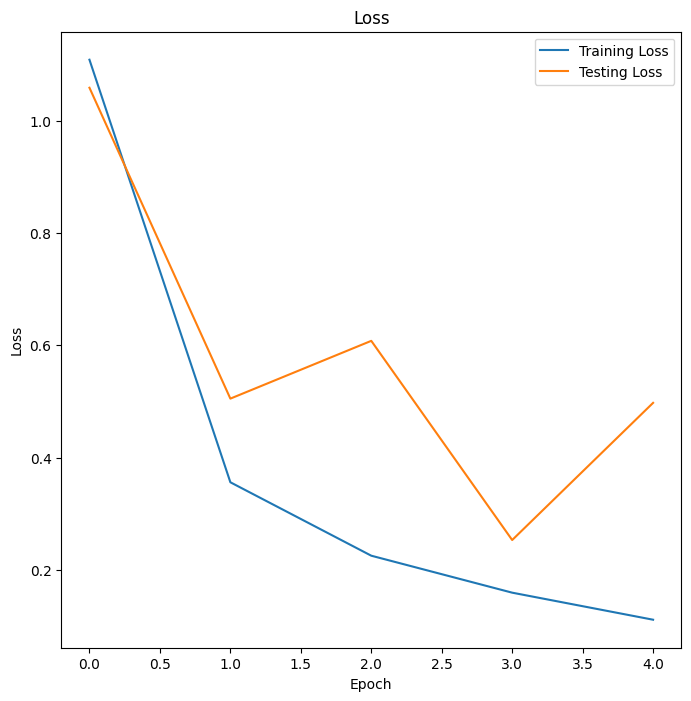

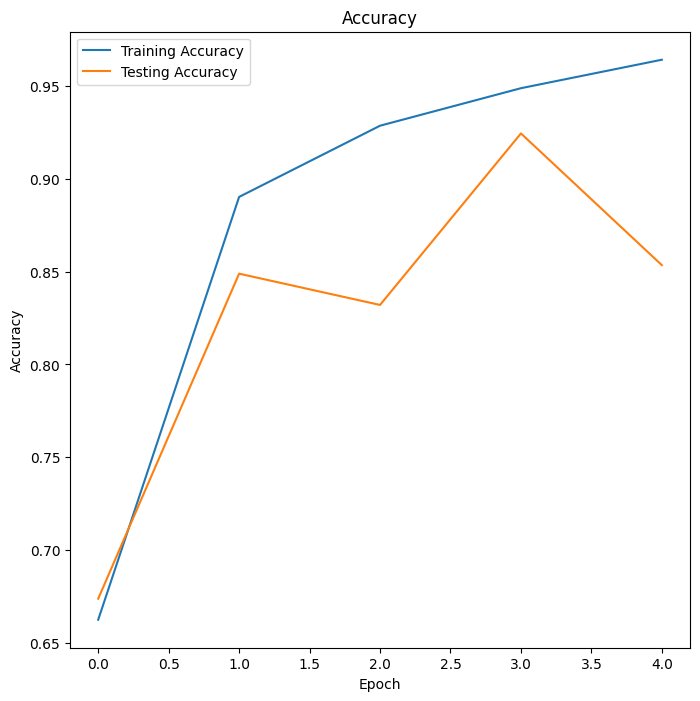

Total images in training dataset: 6779
Total images in testing dataset: 1959


In [5]:
train_data_loader = DataLoader(training_dataset, batch_size=32, shuffle=True)
test_data_loader = DataLoader(testing_dataset, batch_size=32, shuffle=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.000988)

training_losses = []
testing_losses = []
training_accuracies = []
testing_accuracies = []

for epoch in range(5):
    epoch_train_loss = 0
    epoch_test_loss = 0
    epoch_train_accuracy = 0
    epoch_test_accuracy = 0

    model.train()
    for batch_images, batch_labels in tqdm(train_data_loader):
        batch_images = batch_images.to(device)
        batch_labels = batch_labels.to(device)
        optimizer.zero_grad()
        predictions = model(batch_images)
        loss = loss_function(predictions, batch_labels)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()
        epoch_train_accuracy += (predictions.argmax(dim=1) == batch_labels).float().sum().item()

    epoch_train_loss /= len(train_data_loader)
    epoch_train_accuracy /= len(training_dataset)
    training_losses.append(epoch_train_loss)
    training_accuracies.append(epoch_train_accuracy)

    model.eval()
    with torch.no_grad():
        for batch_images, batch_labels in test_data_loader:
            batch_images = batch_images.to(device)
            batch_labels = batch_labels.to(device)
            predictions = model(batch_images)
            loss = loss_function(predictions, batch_labels)
            epoch_test_loss += loss.item()
            epoch_test_accuracy += (predictions.argmax(dim=1) == batch_labels).float().sum().item()

    epoch_test_loss /= len(test_data_loader)
    epoch_test_accuracy /= len(testing_dataset)
    testing_losses.append(epoch_test_loss)
    testing_accuracies.append(epoch_test_accuracy)

    print(f"Epoch {epoch+1}/5, Training Loss: {epoch_train_loss:.4f}, Testing Loss: {epoch_test_loss:.4f}, "
          f"Training Accuracy: {epoch_train_accuracy:.4f}, Testing Accuracy: {epoch_test_accuracy:.4f}")

plt.figure(figsize=(8, 8))
plt.plot(training_losses, label="Training Loss")
plt.plot(testing_losses, label="Testing Loss")
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(8, 8))
plt.plot(training_accuracies, label="Training Accuracy")
plt.plot(testing_accuracies, label="Testing Accuracy")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

print(f"Total images in training dataset: {len(training_dataset)}")
print(f"Total images in testing dataset: {len(testing_dataset)}")

Total images in training dataset: 6779
Total images in testing dataset: 1959
Test Class 1: 156 images
Test Class 3: 194 images
Test Class 4: 206 images
Test Class 0: 144 images
Test Class 2: 147 images
Test Class 6: 84 images
Test Class 10: 71 images
Test Class 16: 110 images
Test Class 15: 74 images
Test Class 9: 86 images
Test Class 13: 79 images
Test Class 17: 85 images
Test Class 7: 123 images
Test Class 11: 100 images
Test Class 5: 61 images
Test Class 12: 84 images
Test Class 14: 85 images
Test Class 8: 70 images
Train Class 1: 471 images
Train Class 3: 635 images
Train Class 4: 640 images
Train Class 0: 588 images
Train Class 2: 523 images
Train Class 8: 265 images
Train Class 6: 279 images
Train Class 12: 291 images
Train Class 16: 407 images
Train Class 17: 313 images
Train Class 11: 341 images
Train Class 9: 324 images
Train Class 10: 298 images
Train Class 5: 221 images
Train Class 15: 258 images
Train Class 7: 363 images
Train Class 14: 299 images
Train Class 13: 263 images

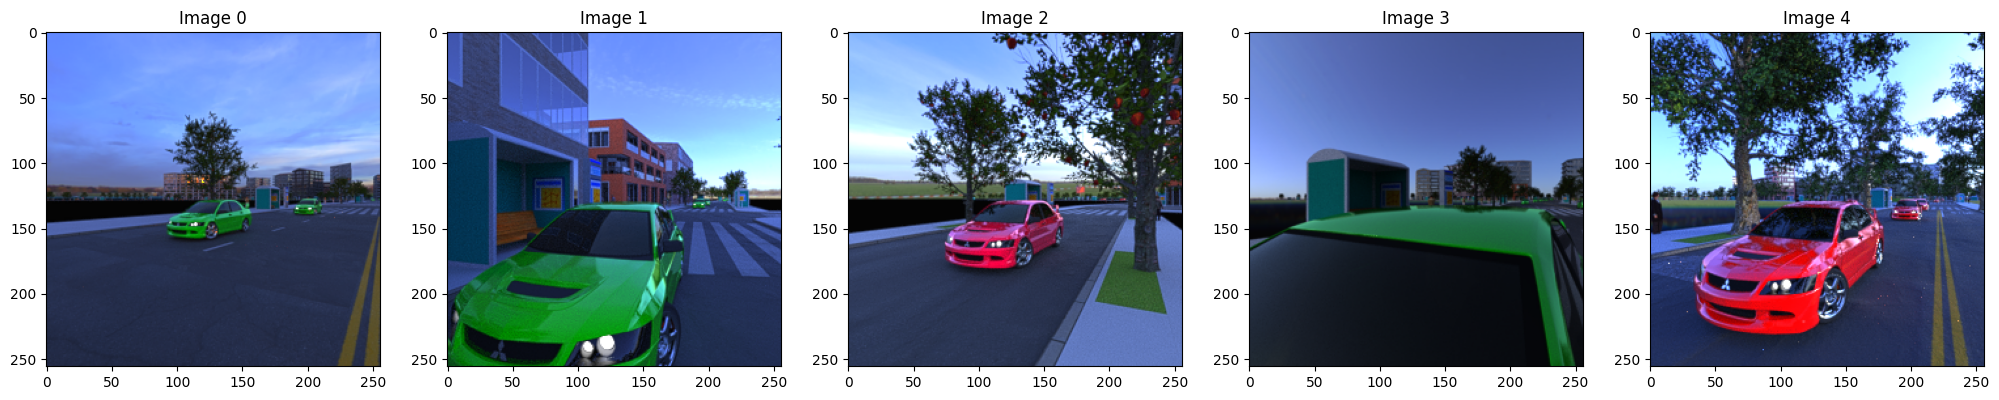

In [6]:
figure, axes = plt.subplots(nrows=1, ncols=5, figsize=(25, 25))
for index in range(5):
    img, lbl = training_dataset[index]
    axes[index].imshow(img.permute(1, 2, 0))
    axes[index].set_title(f"Image {index}")
print(f"Total images in training dataset: {len(training_dataset)}")
print(f"Total images in testing dataset: {len(testing_dataset)}")
for label, count in class_test_counts.items():
    print(f"Test Class {label}: {count} images")
for label, count in class_train_counts.items():
    print(f"Train Class {label}: {count} images")
#Work Cited: Ngu-khoi

1)

a. if do not run over, the overall loss should decreases and accuracy should increase

b.The training loss is expected to decrease initially as the model learns from the data. However, after reaching a certain point, the decrease in training loss would diminish, and simultaneously, the training accuracy could potentially increase to 100%. The validation loss will follow a similar path as the training loss at first but might actually increase when the number of epochs becomes very large. Similarly, the validation accuracy will first increase but then plateau or decrease due to overfitting.


2)

a. It would be 1/18.

b. It would be the same propobility of the most common class.